In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy.io import fits
import glob
import scipy.ndimage

In [12]:
files = glob.glob('/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/*mJy*.fits')
print(files)

['/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/S20190427S0339_podc_distorcorr_rstokesdc_sm2_stpol13-15_quadsub_mJy_arcsec-2.fits', '/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/S20190427S0339_podc_distorcorr_rstokesdc_sm1_stpol13-15_quadsub_mJy_arcsec-2.fits', '/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/S20190427S0339_podc_distorcorr_rstokesdc_sm0_stpol13-15_quadsub_mJy_arcsec-2.fits']


In [13]:
f = '/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/S20190427S0339_podc_distorcorr_rstokesdc_sm0_stpol13-15_quadsub_mJy_arcsec-2.fits'
data = fits.getdata(f)
header = fits.getheader(f)

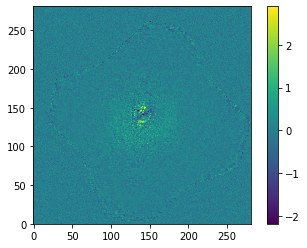

In [14]:
I = data[0,:,:]
Q = data[1,:,:]
Q[np.isnan(Q)] = np.random.randn(len(Q[np.isnan(Q)]))/6
#Q = scipy.ndimage.uniform_filter(Q, size=(5, 5))
plt.imshow(Q)
plt.colorbar()
plt.ylim(0,281)
plt.show()
U = data[2,:,:]
U[np.isnan(U)]=0

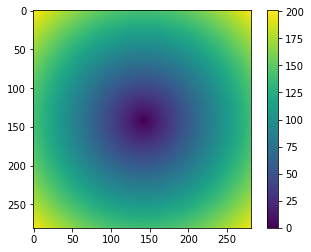

In [15]:
#make radial values array
rad = np.zeros((281,281))
center = [142,142]

for x in range(0,281):  
    for y in range(0,281):
        rad[x,y] = math.sqrt((x-center[0])**2 + (y-center[1])**2)

plt.imshow(rad)
plt.colorbar()

In [16]:
snrimg = np.zeros_like(Q)
noise = np.zeros_like(Q)
image= np.zeros_like(Q)
"""for x in range(0,250,30):
    for y in range(30,280,30):
        pix = np.where((rad>=5) & (rad < 10))
        annulus = U[pix]
        std = np.std(annulus)
        snrimg[pix] = Q[pix]/std"""

width = 1
inner = 0
outer = width
avg_SNR = []
avg_rad = []
    
while outer<=100.0:
    pix = np.where((rad>=inner) & (rad < outer))
    annulus = U[pix] 
    std = np.std(annulus)
    noise[pix] = std
    image[pix] = Q[pix]
    snrimg[pix] = Q[pix]/std
    avg_SNR.append(np.average(snrimg[pix]))
    avg_rad.append((inner+outer)/2)
    inner = inner + width
    outer = outer + width

/Users/blewis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


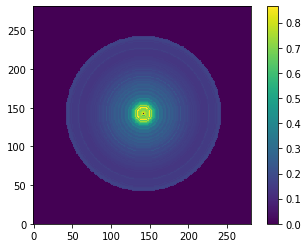

(array([142]), array([142]))


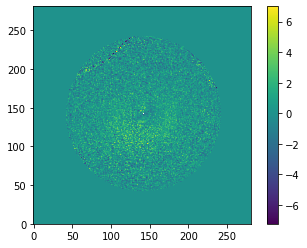

In [17]:
plt.imshow(noise,vmin=0)
plt.colorbar()
plt.ylim(0,281)
plt.savefig('../plots/HD156623-noise.png')
plt.show()
plt.imshow(snrimg,vmax=7)
plt.ylim(0,281)
plt.colorbar()
plt.savefig('../plots/HD156623-SNR.png',dpi=500)
print(np.where(snrimg==-np.inf))
snrimg[142,142]=0

In [18]:
sigma2 = noise**2
sigmasm = scipy.ndimage.uniform_filter(sigma2, size=(5, 5))
Qsm = scipy.ndimage.uniform_filter(Q, size=(5, 5))
SNR_sm = Qsm/np.sqrt(sigmasm)

/Users/blewis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


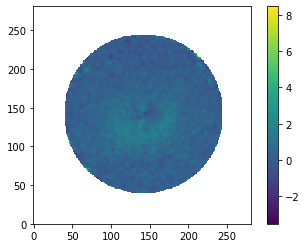

In [19]:
plt.imshow(SNR_sm)
plt.ylim(0,281)
plt.colorbar()
plt.savefig('../plots/HD156623-SNR-smoothed.png',dpi=500)

### Investigating that possible inner hole bit?

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1   152.0   141.0 130.19776732490126
    aperture_sum   
-------------------
0.28780025346231236


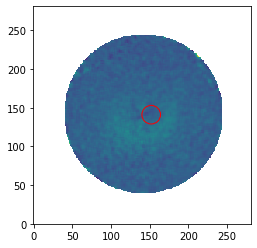

In [20]:
import matplotlib.patches as mpatches
plt.imshow(SNR_sm)
plt.ylim(0,281)
circle1 = mpatches.Circle((152, 141), 12, color='r',fill=False)
ax = plt.gca()
ax.add_artist(circle1)

#hdu = fits.PrimaryHDU(SNR_sm)
#hdu.writeto('smoothed-snr.fits',overwrite=True)

from photutils.aperture import CircularAperture
aperture = CircularAperture((152, 141), r=12.)
from photutils.aperture import aperture_photometry
phot = aperture_photometry(snrimg, aperture)
print(phot)
avg_spot = phot['aperture_sum']/(np.pi*(12**2))
print(avg_spot)

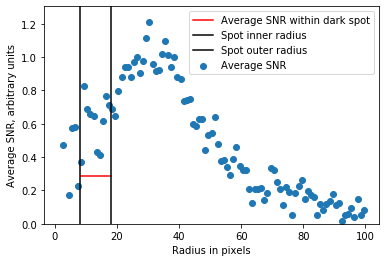

In [21]:
#SNR at each radius, to compare with that hole
plt.scatter(avg_rad,avg_SNR,label='Average SNR')
plt.ylim(0,)
plt.xlabel('Radius in pixels')
plt.ylabel('Average SNR, arbitrary units')
#average SNR over spot is saved as avg_spot
plt.axhline(avg_spot,color='red',label='Average SNR within dark spot',xmin=0.11,xmax=0.2)
#inner radius of dark smudge = 8
plt.axvline(8,color='black',label="Spot inner radius")
#outer radius of dark smudge = 18
plt.axvline(18,color='black',label="Spot outer radius")
plt.legend()
plt.savefig('../plots/spot-snr-comparison.png',dpi=500)